In [249]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np
from scipy.signal import find_peaks

# load recorded data & print statistics
load all data and compute basic statistics on the complete data set

In [250]:
#data = np.loadtxt("/home/pi/src/radiometer/data/adc_data_010320232309.csv") # reading in volts
data = np.loadtxt("/tmp/adc_data.csv") # reading in volts

print('n:{:>19d}'.format(len(data)))
print('median: {: .6e}'.format(np.median(data)))
print('mean:   {: .6e}'.format(np.mean(data)))
#print('max:    {: .6e}'.format(np.max(data)))
#print('min:    {: .6e}'.format(np.min(data)))
print('std:    {: .6e}'.format(np.std(data)))
print('p2p:    {: .6e}'.format(np.max(data)-np.min(data)))
#print(' 0.05%: {: .6e}'.format(np.percentile(data, 0.05)))
#print('99.95%: {: .6e}'.format(np.percentile(data,99.95)))
print('99.9%:  {: .6e}'.format(np.percentile(data,99.95)-np.percentile(data, 0.05))) 
#Should be equivalent to 6.6 x sigma or 6.6 x std, assuming a gaussian distribution.


n:             442915
median:  9.813393e-01
mean:    9.813047e-01
std:     6.993709e-02
p2p:     1.995468e-01
99.9%:   1.988489e-01


# plot recorded data
plot a limited slice of the recorded data, from a predefined starting point, a predefined number of smaples 

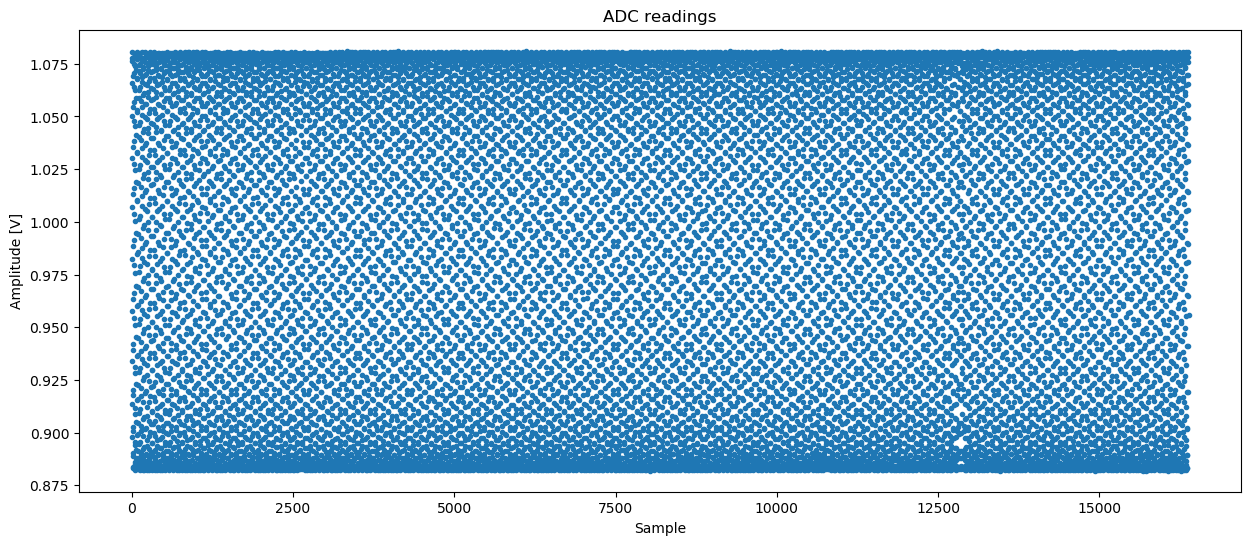

In [251]:
n = 2**14 # number of samples
s = 200 # starting sample
y = data[s:s+n]

fig, axis = plt.subplots(figsize =(15, 6), facecolor=(1,1,1))
axis.plot(y, '.')
axis.set_ylabel('Amplitude [V]')
#axis.set_xlabel('Voltage [$\mu V$]')
axis.set_xlabel('Sample')
#axis.set_xlabel('Voltage [V]')
axis.set_title(r'ADC readings')
#plt.grid()
plt.savefig('adc_readings.png', bbox_inches='tight')
plt.show()

# plot recorded data histogram

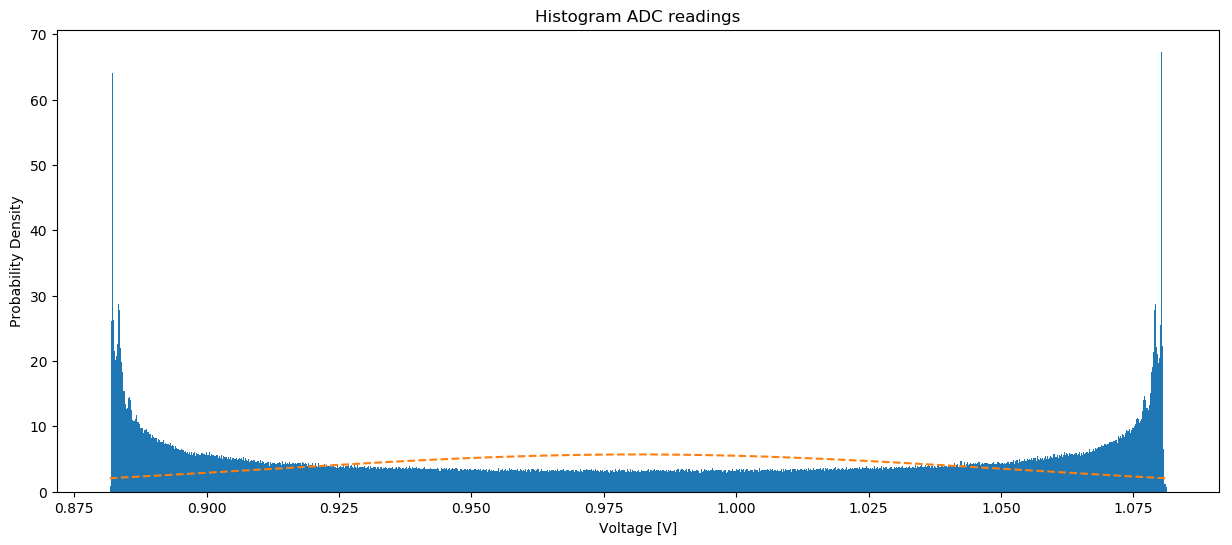

In [252]:
fig, axis = plt.subplots(figsize =(15, 6), facecolor=(1,1,1))

# create histogram
n, bins, patches = axis.hist(data, bins=1000, density=True)

# add a 'best fit' line
sigma = np.std(data)
mu = np.mean(data)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
axis.plot(bins, y, '--')
axis.set_ylabel('Probability Density')
#axis.set_xlabel('Voltage [$\mu V$]')
axis.set_xlabel('Voltage [V]')
#axis.set_xlabel('Voltage [V]')
axis.set_title(r'Histogram ADC readings')
#plt.grid()
plt.savefig('histogram.png', bbox_inches='tight')
plt.show()

# compute real FFT & find peaks

In [253]:
data_rate = 2463 # fill in the sample rate reported by the rpi_adc_stream comman
freq_bins = np.fft.rfftfreq(data.size, d=1/data_rate)
bin_width = data_rate/data.size
spectrum  = 1/data.size * (np.fft.rfft(data, norm='backward'))
spectrum[1:]  = (spectrum[1:]) * 2 # compensate for 'real' FFT

peaks, _ = find_peaks(np.abs(spectrum), height=0.001, distance=10000) # find all peaks >= 2.0 uV^2/Hz
peaks.resize(peaks.size+1) # peaks consistently misses the first index (DC, 0 Hz) 
peaks.sort()               # by resizing and sorting this is corrected

print('samples    :', data.size)
print('bins       :', freq_bins.size)
print('DC         :','{: .5e}'.format(np.abs(spectrum[0])))
print('bin width  :','{: .5e}'.format(bin_width))
#print('Vnoise_rms :','{: .5e}'.format((np.sum(np.abs(spectrum)*bin_width)-np.abs(spectrum[0]*bin_width))/2*1.57))
# Somehow just taking the total sum of the real part and dividing by 2 gives an accurate result for just gaussian noise. Why?
# it seems to work only for long measurement intervals > 100s? 1.57 is the correction factor for a 1 pole filter.
print('\nPeaks:\n')
print('Freq. [Hz]    |  Ampl. [dBV] ')
print('--------------|--------------')
for i in peaks:
    print('{: .5e}'.format(freq_bins[i]),'  |','{: .5e}'.format(20 * np.log10(np.abs(spectrum[i]))))


samples    : 442915
bins       : 221458
DC         :  9.81305e-01
bin width  :  5.56089e-03

Peaks:

Freq. [Hz]    |  Ampl. [dBV] 
--------------|--------------
 0.00000e+00   | -1.63923e-01
 1.00001e+02   | -2.94602e+01


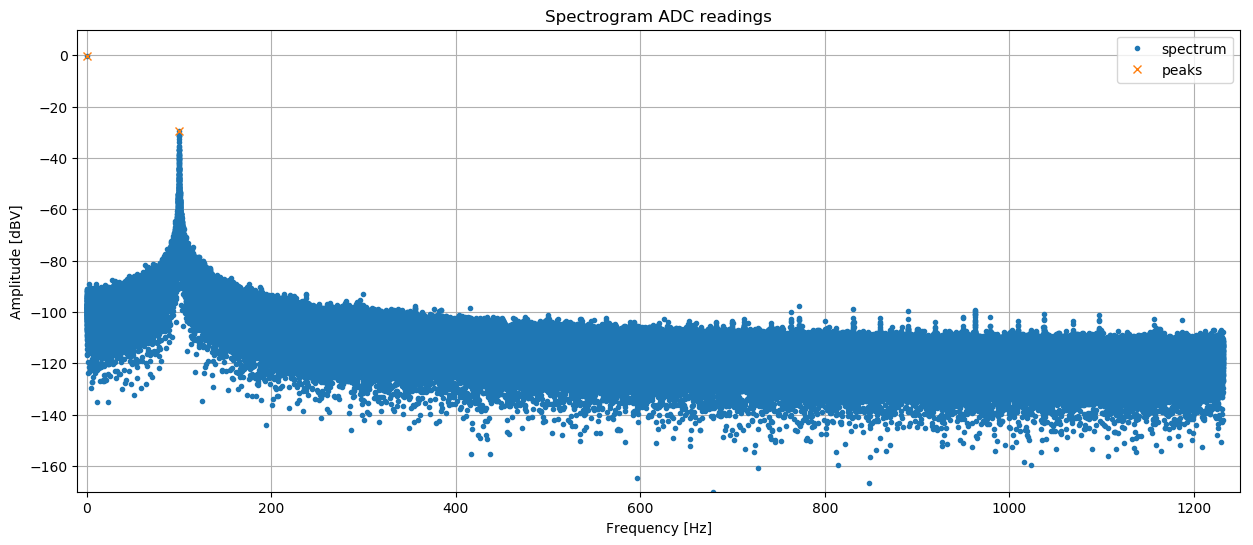

In [254]:
fig, axis  = plt.subplots(figsize =(15, 6), facecolor=(1,1,1))

axis.plot(freq_bins, 20 * np.log10(np.abs(spectrum)), '.', label='spectrum')
axis.plot(freq_bins[peaks], 20 * np.log10(np.abs(spectrum[peaks])), 'x', label='peaks' )

axis.set_xlabel('Frequency [Hz]')
axis.set_ylabel('Amplitude [dBV]')
axis.set_title(r'Spectrogram ADC readings')
plt.ylim(-170,10)
plt.xlim(-1e1,1.25e3)
plt.grid()
plt.legend()
plt.savefig('spectrogram.png', bbox_inches='tight') 
plt.show()

# compute average real fft & find peaks

In [255]:
data_rate = 2463 # fill in the sample rate reported by the rpi_adc_stream command
points = (2 ** 15)
frames = int(data.size/points)
freq_bins = np.fft.rfftfreq(points, d=1/data_rate)
bin_width = data_rate/points
spectrum_    = np.zeros(freq_bins.size)
spectrum_avg = np.zeros(freq_bins.size)
print(points)
print(freq_bins.size)
print(frames)

for i in range(frames):
    spectrum_  = np.abs(np.fft.rfft(data[i*points:(i+1)*points], norm='forward'))
    spectrum_[1:]  = (spectrum_[1:]) * 2 # compensate for 'real' FFT
    spectrum_avg = np.add(spectrum_avg, spectrum_)
spectrum_avg  = (spectrum_avg) / frames # compensate for 'real' FFT

peaks_avg, _ = find_peaks(np.abs(spectrum_avg), height=0.001, distance=10000) # find all peaks >= 2.0 uV^2/Hz
peaks_avg.resize(peaks_avg.size+1) # peaks consistently misses the first index (DC, 0 Hz) 
peaks_avg.sort()               # by resizing and sorting this is corrected

print('\nPeaks:\n')
print('Freq. [Hz]    |  Ampl. [dBV] ')
print('--------------|--------------')
for i in peaks_avg:
    print('{: .5e}'.format(freq_bins[i]),'  |','{: .5e}'.format(20 * np.log10(np.abs(spectrum_avg[i]))))


32768
16385
13

Peaks:

Freq. [Hz]    |  Ampl. [dBV] 
--------------|--------------
 0.00000e+00   | -1.63927e-01
 1.00044e+02   | -2.49665e+01


# plot average real FFT and peaks

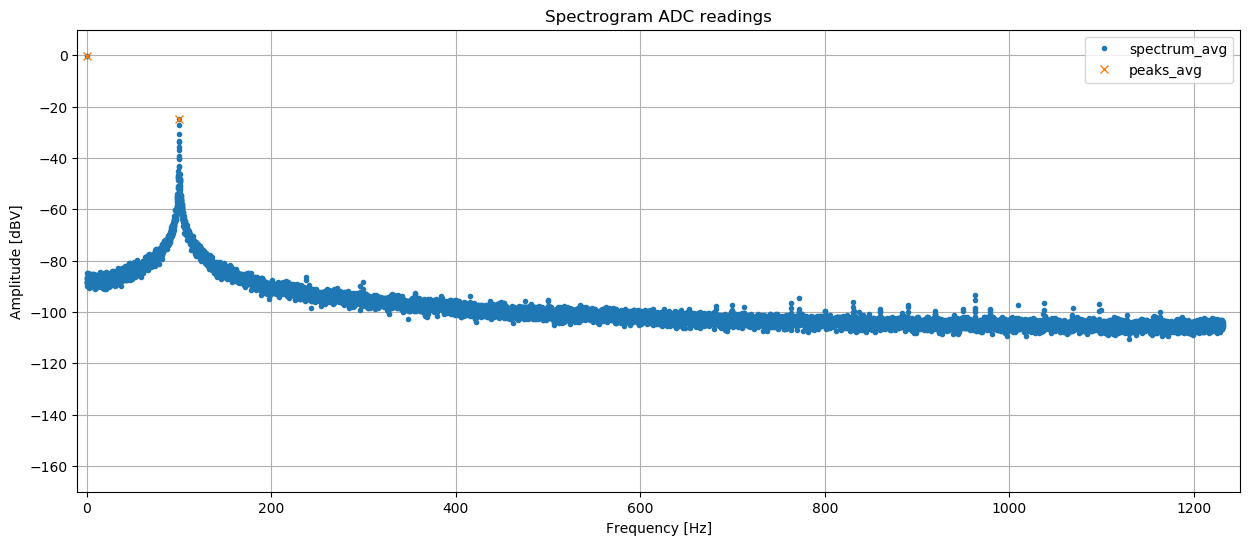

In [256]:
fig, axis  = plt.subplots(figsize =(15, 6), facecolor=(1,1,1))

axis.plot(freq_bins, 20 * np.log10(np.abs(spectrum_avg)), '.', label='spectrum_avg')
axis.plot(freq_bins[peaks_avg], 20 * np.log10(np.abs(spectrum_avg[peaks_avg])), 'x', label='peaks_avg' )

axis.set_xlabel('Frequency [Hz]')
axis.set_ylabel('Amplitude [dBV]')
axis.set_title(r'Spectrogram ADC readings')
plt.ylim(-170,10)
plt.xlim(-1e1,1.25e3)
plt.grid()
plt.legend()
plt.savefig('average_spectrogram.png', bbox_inches='tight') 
plt.show()

In [257]:
fft_points = (2 ** 12)
#time_step  = 1./data_rate
#bin_width  = 1/(data.size*time_step)
bin_width = data_rate/fft_points
freq_bins  = np.fft.rfftfreq(fft_points, d=1/data_rate)
waterfall  = np.empty((int(data.size/fft_points),int(fft_points/2)+1))
background = np.empty(int(data.size/fft_points))
total      = np.empty(int(data.size/fft_points))
print(waterfall.shape)
for i in range(int(data.size/fft_points)):
    waterfall[i,]   = np.abs(np.fft.rfft(data[i*fft_points:(i+1)*fft_points], norm='forward'))
    waterfall[i,1:] = waterfall[i,1:] * 2
    background[i]   = waterfall[i,0]
    total[i]        = np.sum(waterfall[i,])

(108, 2049)


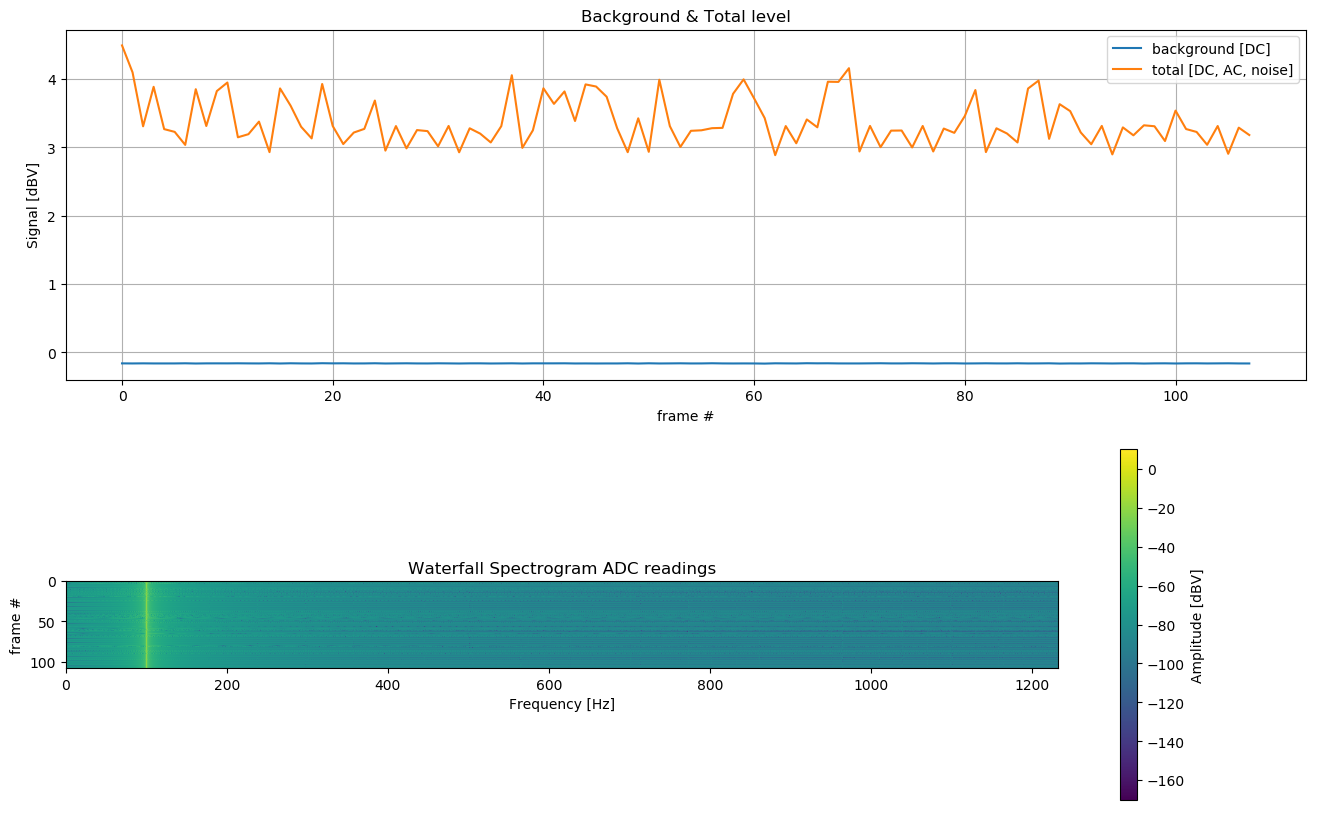

In [258]:
fig, (axis1,axis2) = plt.subplots(2,1, figsize =(16, 10), facecolor=(1,1,1))
plot2 = axis2.imshow(20*np.log10(waterfall), extent=[np.min(freq_bins),np.max(freq_bins),int(data.size/fft_points),0], vmin=-170,vmax=10) # vmin=10e-5,vmax=10e1, norm=colors.Normalize()
fig.colorbar(plot2, label='Amplitude [dBV]')
axis2.set_ylabel('frame #')
axis2.set_xlabel('Frequency [Hz]')
axis2.set_title(r'Waterfall Spectrogram ADC readings')
plot1 = axis1.plot(20*np.log10(background),'-', label='background [DC]')
plot1 = axis1.plot(20*np.log10(total),'-',label='total [DC, AC, noise]')
#axis1.set_ylim(-35,-20)
#axis1.set_xlim(5100,5200)
axis1.grid()
axis1.set_ylabel('Signal [dBV]')
axis1.set_xlabel('frame #')
axis1.set_title(r'Background & Total level')
axis1.legend()
plt.savefig('waterfall.png', bbox_inches='tight')
plt.show()